### SCeptre workflow for MS2 750ms dataset

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sceptre as spt

In [2]:
m = 'MS2_750'

In [3]:
# create result folder
res_dir = f'../results/scMS/{m}/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [4]:
spt.create_meta_data(f"../data/{m}/", res_dir)

dataset = spt.load_dataset(proteins = f"../data/{m}/{m}_Proteins.txt",
                       psms = f"../data/{m}/{m}_PSMs.txt",
                       msms = f"../data/{m}/{m}_MSMSSpectrumInfo.txt",
                       files = f"../data/{m}/{m}_InputFiles.txt",
                       meta = res_dir + "meta.txt")

In [5]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
dataset['proteins']['contaminant'] = dataset['proteins']['Accession'].isin(contaminants)
dataset['proteins'] = dataset['proteins'][dataset['proteins']['contaminant']==False]

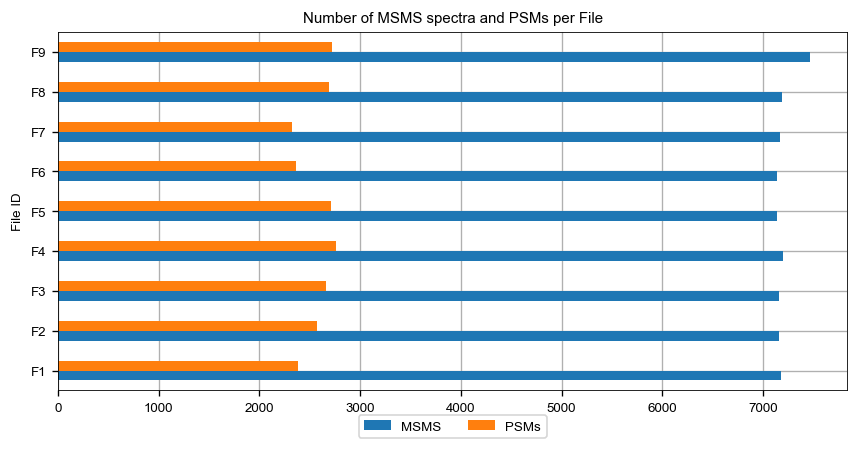

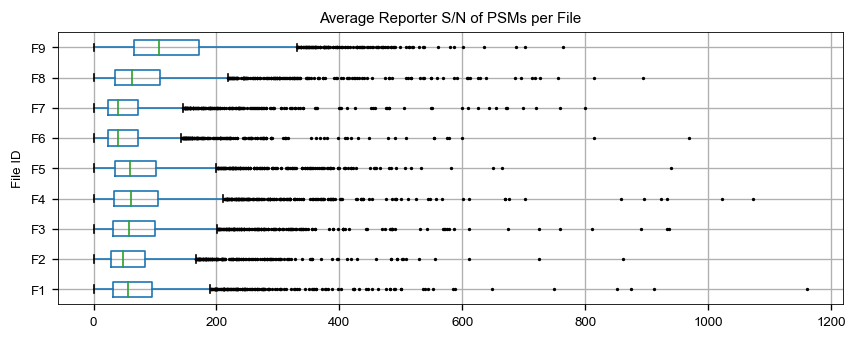

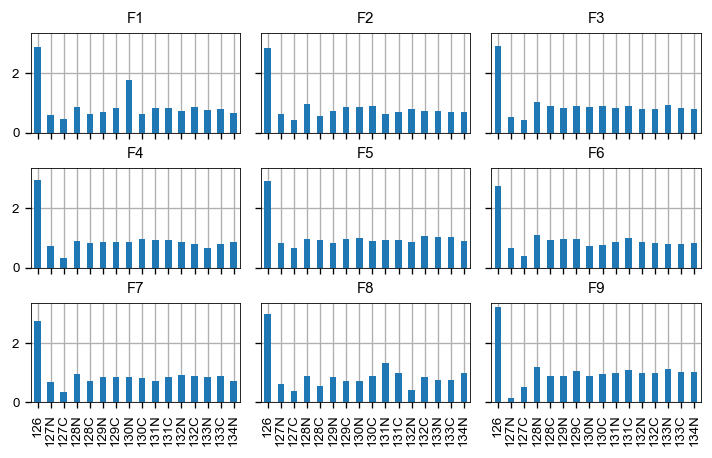

In [6]:
spt.plot_psms_msms(dataset)
spt.plot_avg_sn(dataset)
spt.plot_set_overview(dataset, figsize=(7.2, 4))

In [7]:
s_c_channels = ['127N', '128N', '128C', '129N', '129C', '130N', '130C',
            '131N','131C', '132N', '132C', '133N', '133C', '134N']
spt.print_ms_stats(dataset, s_c_channels=s_c_channels)

Protein IDs: 1269
Peptide IDs: 5240
PSMs: 23187
PSM rate: 0.358
Median of median S/N in single-cell channels: 7.35
Median of mean S/N in single-cell channels: 11.061
Median S/N of booster channel: 835.5
Mean protein IDs per file: 790.0


In [8]:
adata = spt.dataset_to_scanpy(dataset)

In [9]:
# normalize facs parameter between 0 and 1
fasc_params = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34', 'CD38']
adata.obs[fasc_params] = adata.obs[fasc_params].apply(lambda x: (x-x.min())/(x-x.min()).max())
# rename facs parameter
adata.obs = adata.obs.rename(columns={'CD34': 'CD34 APC-Cy7-A', 'CD38': 'CD38 PE-A'})

# transform meta columns to categories
adata.obs["Column"] = adata.obs["Column"].astype(pd.Int64Dtype()).astype("category")
adata.obs["Plate"] = adata.obs["Plate"].astype(str).astype("category")
# object columns to category
adata.obs.loc[:, adata.obs.dtypes == "object"] = adata.obs.select_dtypes(["object"]
                                                                          ).apply(lambda x: x.astype("category"))
# order some columns
adata.obs["File ID"] = adata.obs["File ID"].cat.reorder_categories(adata.obs["File ID"].unique(), ordered=True)
adata.obs["Channel"] = adata.obs["Channel"].cat.reorder_categories(adata.obs["Channel"].unique(), ordered=True)

# set colors for sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[2], cols[1], cols[0]]

# remove non-single-cell channels
adata = adata[adata.obs['Channel'] != '126'].copy()
adata = adata[adata.obs['Channel'] != '127C'].copy()

/home/bfurtwa/miniconda3/envs/sceptre/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


performed 26 iterations
358 values below 1.1 were set to 0
filtered out 21 genes that are detected in less than 1 cells
8 of 126 cells do not pass filter
removed 8 cells
filtered out 116 genes that are detected in less than 10 cells


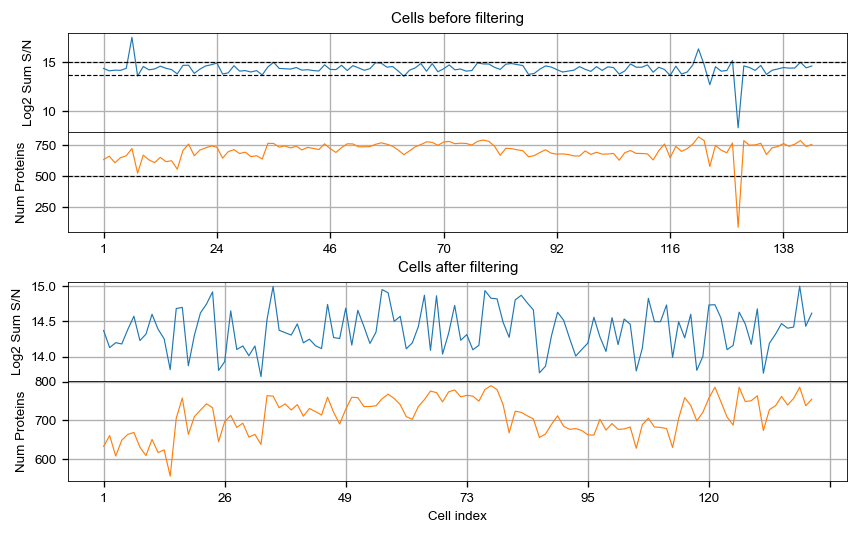

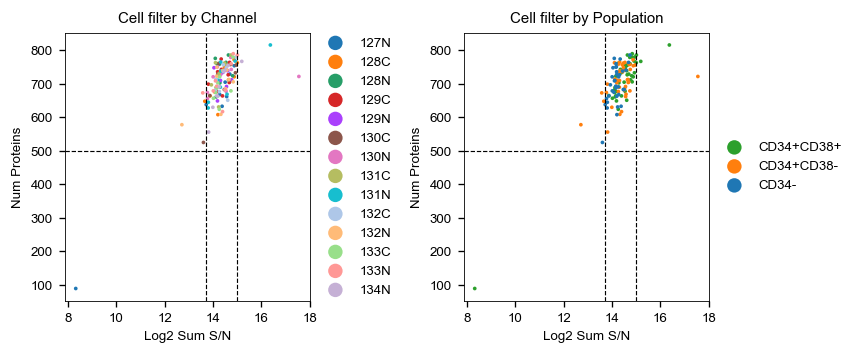

In [10]:
spt.normalize(adata)
figs = spt.calculate_cell_filter(adata, thresh_sum=2, min_proteins=500)
spt.apply_cell_filter(adata, min_cells=10)

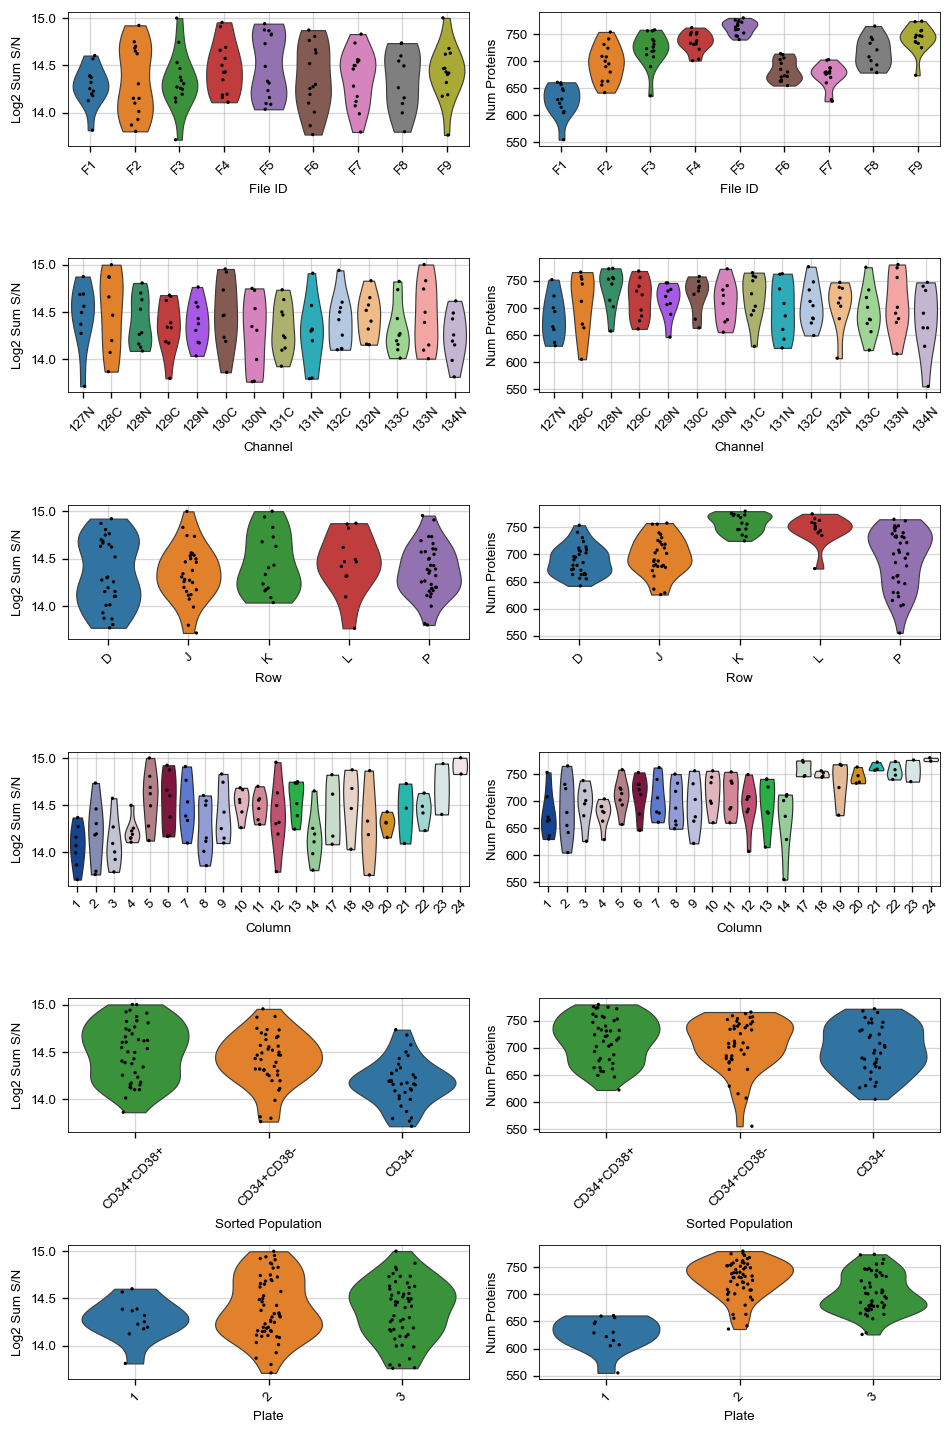

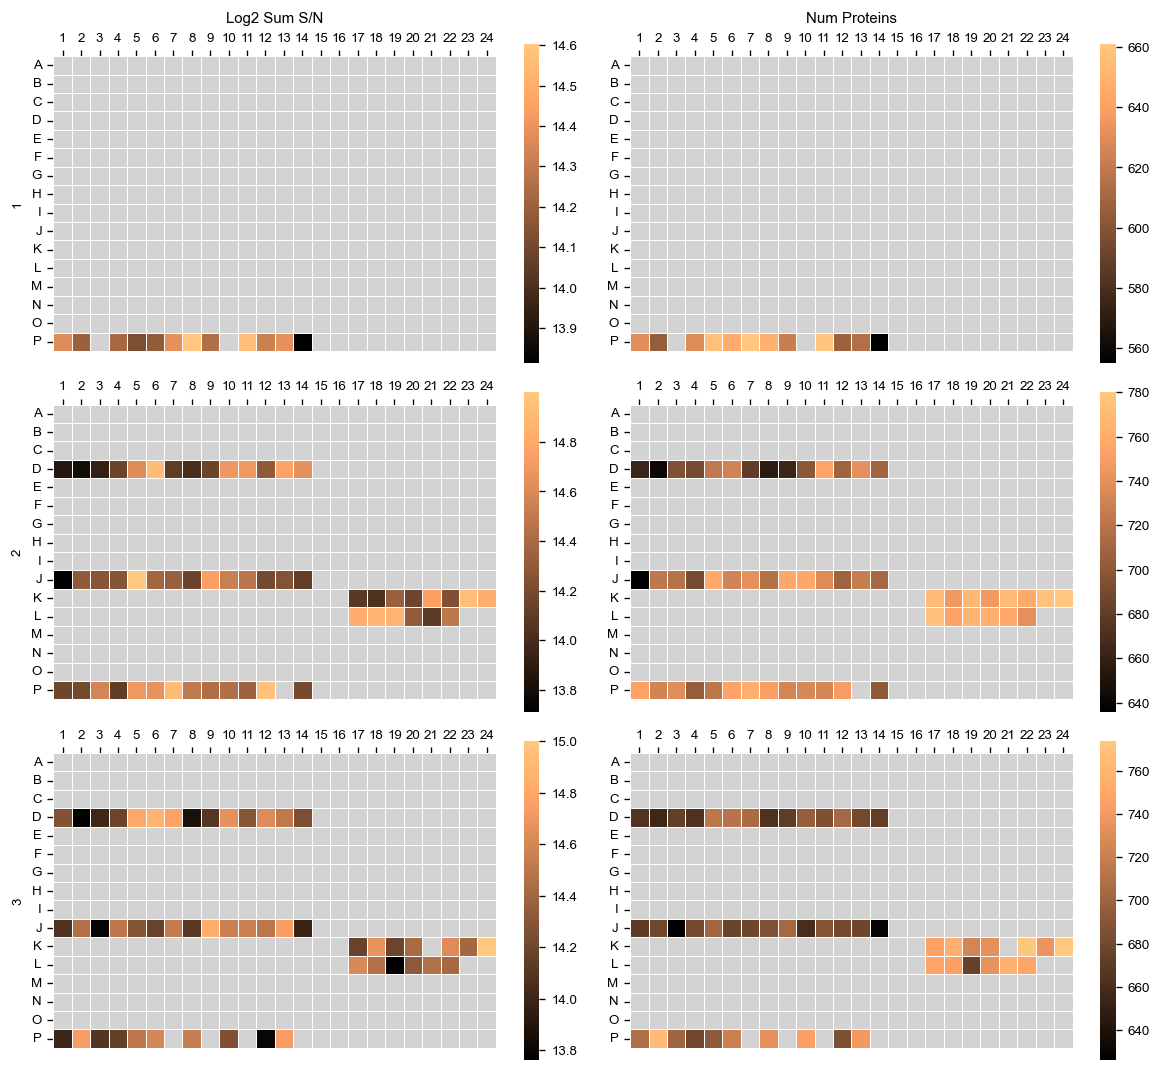

In [11]:
spt.plot_batch_qc(adata, groupby=['File ID', 'Channel', 'Row', 'Column', 'Sorted Population', 'Plate'], figsize=(8, 12))
spt.plot_plate_qc(adata, figsize=(10, 9))

mean protein IDs per cell: 707.2
median protein IDs per cell: 710.5
percent missing values: 37.19


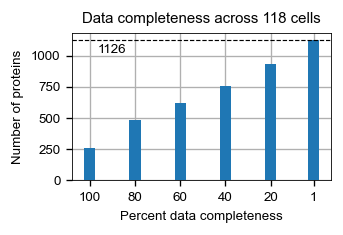

In [12]:
spt.plot_data_completeness(adata)

/home/bfurtwa/miniconda3/envs/sceptre/lib/python3.7/site-packages/sceptre/sceptre.py:1060: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


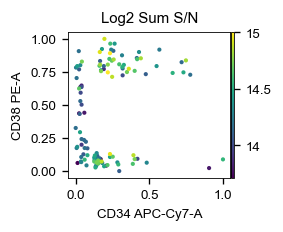

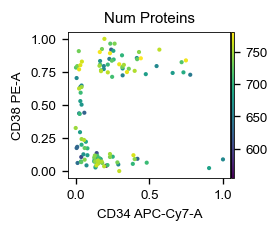

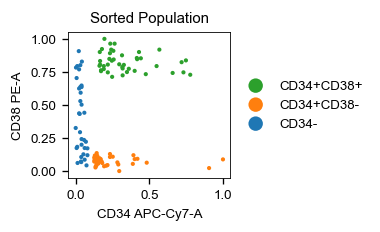

In [13]:
figs = spt.plot_facs_qc(adata, 'CD34 APC-Cy7-A', 'CD38 PE-A', labels=['Log2 Sum S/N', 'Num Proteins', 'Sorted Population'])

In [14]:
# median shift of total intensity across cells
sc.pp.normalize_total(adata, exclude_highly_expressed=True) 
# log2(x+1) transformation
sc.pp.log1p(adata, base=2)
# save the normalized and log2 transformed data as raw data for differential expression testing
adata.raw = adata

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['VIM', 'ANXA2', 'S100A8', 'LYZ']
    finished (0:00:00)


In [15]:
# impute
spt.impute(adata)
# scale to unit variance and zero mean
sc.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 118 × 1126
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', '7-AAD', 'Time', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells', 'mean', 'std'
    uns: 'Sorted Population_colors', 'Channel_colors', 'File ID_colors', 'Row_colors', 'Column_colors', 'Plate_colors', 'log1p'

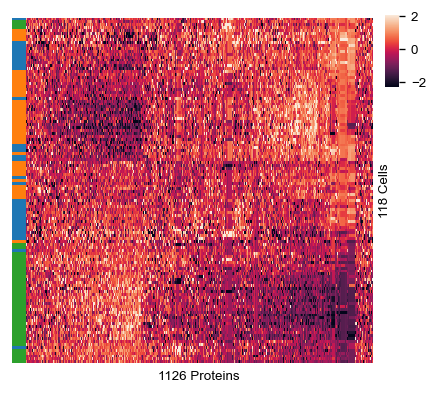

In [16]:
ax = sc.pl.clustermap(adata, obs_keys='Sorted Population', metric='correlation',
                      use_raw=False, robust=True, xticklabels=False, yticklabels=False,
                      show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata.shape[1]), ylabel='{} Cells'.format(adata.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

In [17]:
plot_parameters = ['Sorted Population', 'File ID', 'Channel', 'Plate',
                   'Row', 'Column', 'Num Proteins', 'Log2 Sum S/N', 'Time', 'FSC-A', 'FSC-H',
                   'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A']
# set cmaps for plot parameters
plot_cmaps = {'Num Proteins': 'copper', 'Log2 Sum S/N': 'copper', 'Time': 'copper',
             'FSC-A': 'cividis', 'FSC-H': 'cividis', 'FSC-W': 'cividis', 'SSC-A': 'cividis',
             'SSC-H': 'cividis', 'SSC-W': 'cividis', 'CD34 APC-Cy7-A': 'cividis', 'CD38 PE-A': 'cividis'}

# plotting options for panels
figsize = (9, 15.5)
wspace = 1
hspace = 0.7
cellsize= 30 # size to plot cells

In [18]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:02)


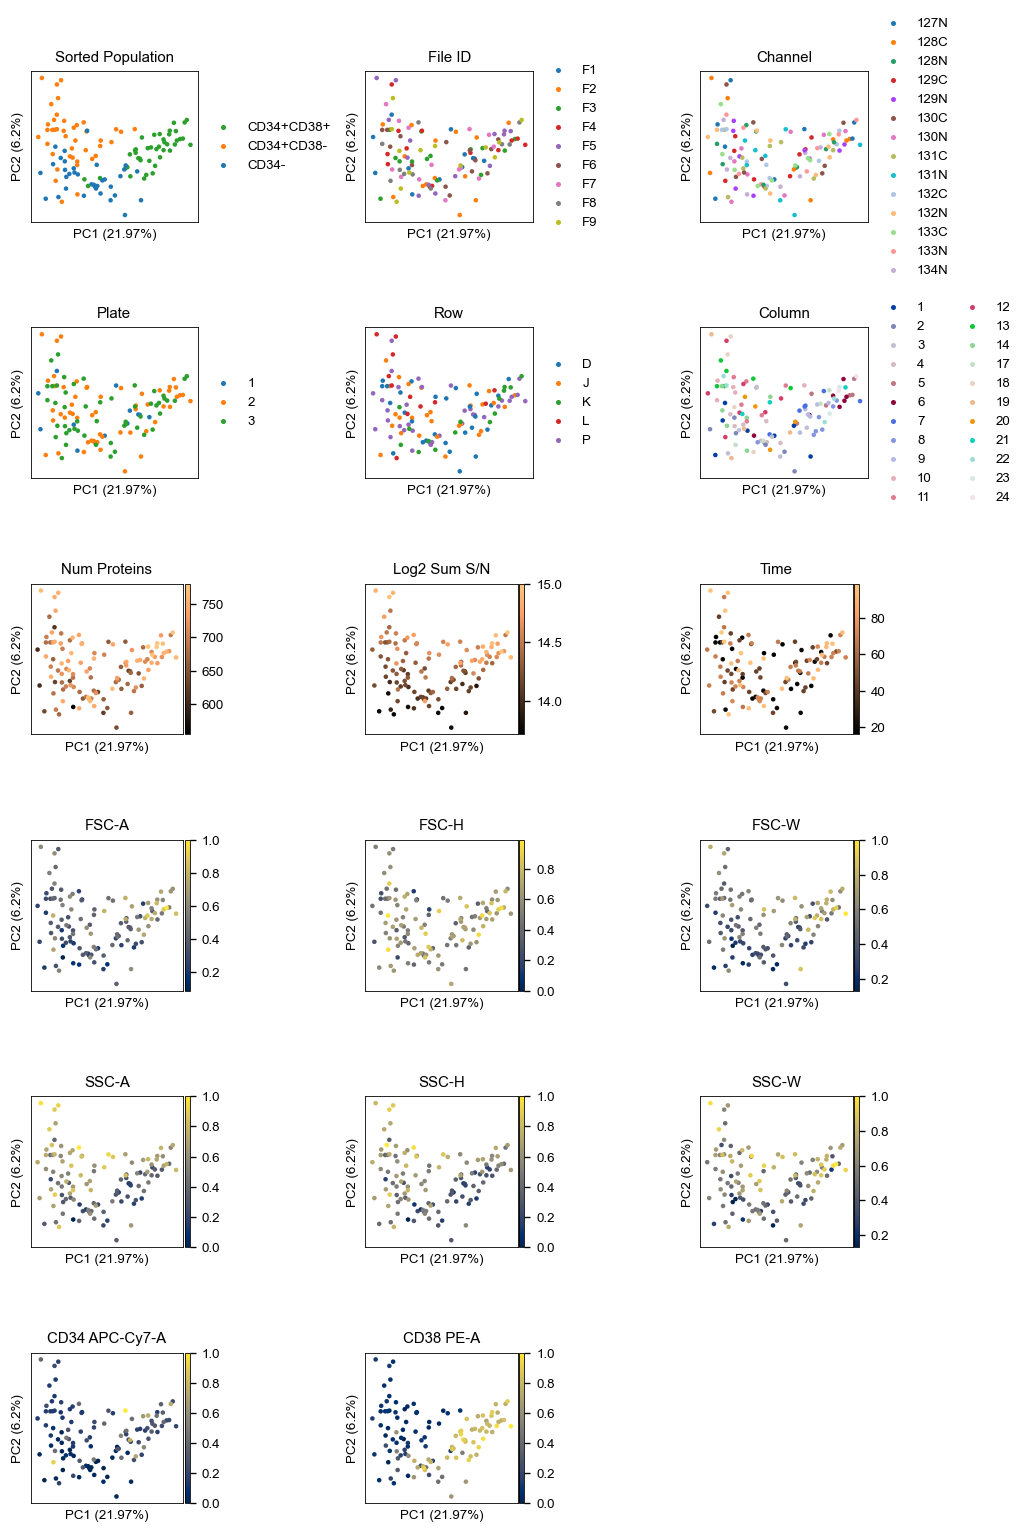

In [19]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.pca(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, annotate_var_explained=True)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "pca.pdf", bbox_inches='tight', transparent=True)

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


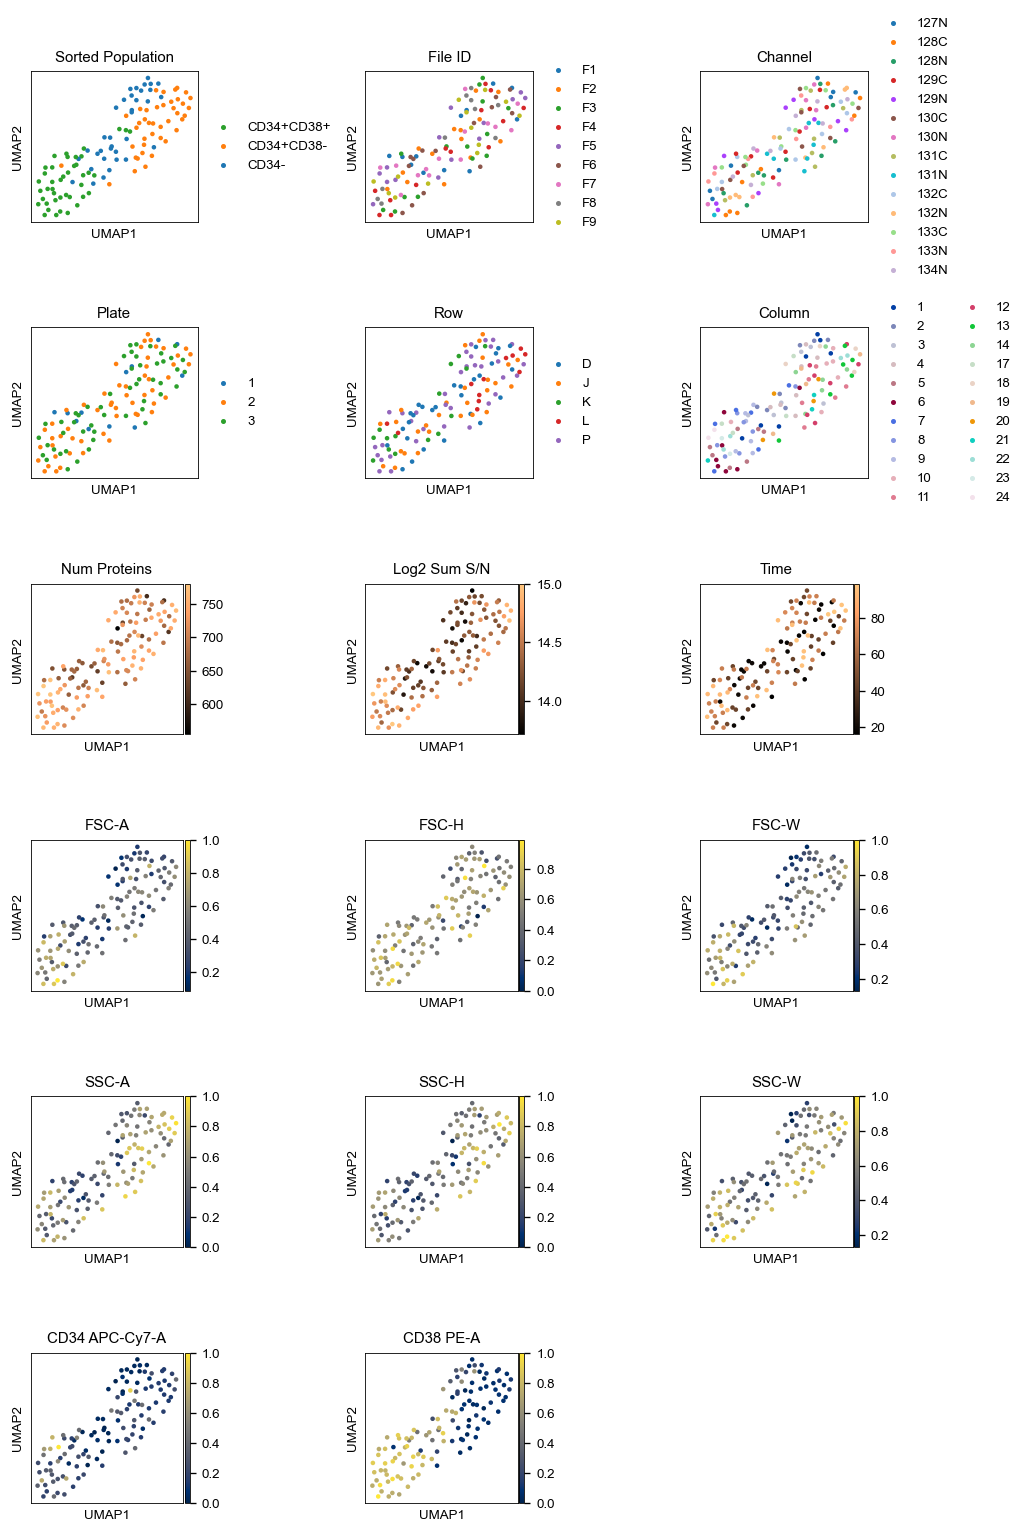

In [21]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.umap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "umap.pdf", bbox_inches='tight', transparent=True)

In [22]:
# save adata
adata.write(res_dir + f"{m}.h5ad")

In [24]:
os.system('jupyter nbconvert --to html MS2_750.ipynb --output-dir={}'.format(res_dir))

[NbConvertApp] Converting notebook MS2_750.ipynb to html
[NbConvertApp] Writing 2496583 bytes to ../results/scMS/MS2_750/MS2_750.html


0